In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as ipyw

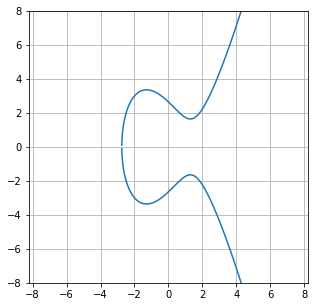

In [2]:
#
# Plotting curve
#   y^2 = x^3 + ax + b
#
# cf.
# https://en.wikipedia.org/wiki/Elliptic_curve
# https://github.com/bitcoin-core/secp256k1/blob/master/sage/secp256k1_params.sage
#

def _(a=0, b=7):
    import warnings
    lim = [-8, 8]
    num_samples = 1000
    x = np.linspace(*lim, num_samples)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', 'invalid value encountered in sqrt')
        y = (x ** 3 + a * x + b) ** 0.5    
    fig, ax = plt.subplots(figsize=[5, 5])
    ax.grid()
    ax.axis('equal')
    ax.set(xlim=lim, ylim=lim)
    ax.plot(x, y, 'C0')
    ax.plot(x, -y, 'C0')


# Interactively
# ipyw.interact(_, a=(-10, 10, 0.1), b=(-10, 10, 0.05))

_(a=-5, b=7)

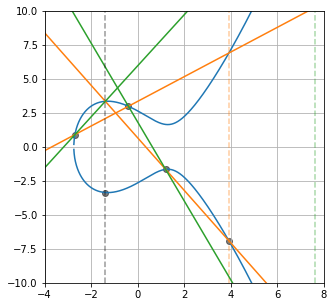

In [3]:
#
# Visualize group structure (associatibity of addition)
#

def _(x1=-2.7, x2=-0.4, x3=1.2, show_p12=True, show_p23=True):
    a = -5
    b = 7
    x_lim = [-4, 8]
    y_lim = [-10, 10]
    num_samples = 2000


    def solve_y(x):
        import warnings
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore')
            y = (x ** 3 + a * x + b) ** 0.5
        return y

    
    def add(p1, p2):
        x1, y1 = p1
        x2, y2 = p2
        assert x1 != x2
        s = (y2 - y1) / (x2 - x1)
        x3 = s ** 2 - x1 - x2
        y3 = s * (x3 - x1) + y1
        return (x3, -y3)


    def inverse(p):
        return (p[0], -p[1])

    
    def plot_ec(ax, *args, **kwargs):
        x = np.linspace(*x_lim, num_samples)
        y = solve_y(x)
        ax.plot(x, y, *args, **kwargs)
        ax.plot(x, - y, *args, **kwargs)

        
    def plot_line(ax, p1, p2, *args, **kwargs):
        x1, y1 = p1
        x2, y2 = p2
        if x1 == x2:
            y = np.linspace(*y_lim, 10)
            x = x1 * np.ones_like(y)
            ax.plot(x, y, *args, **kwargs)            
        else:
            s = (y2 - y1) / (x2 - x1)
            x = np.linspace(*x_lim, 10)
            y = s * (x - x1) + y1
            ax.plot(x, y, *args, **kwargs)


    p1 = (x1, solve_y(x1))
    p2 = (x2, solve_y(x2))
    p3 = (x3, -solve_y(x3))
    
    p12 = add(p1, p2)
    p23 = add(p2, p3)
    p123 = add(p12, p3)

    pts = np.array([p1, p2, p3, p12, p123])

    fig, ax = plt.subplots(figsize=[5, 5])
    ax.grid()
    ax.set(xlim=x_lim, ylim=y_lim)
    plot_ec(ax, 'C0')
    if show_p12:
        plot_line(ax, p1, p2, 'C1')
        plot_line(ax, p12, p3, 'C1')
        plot_line(ax, p12, inverse(p12), '--C1', alpha=0.4)
    if show_p23:
        plot_line(ax, p2, p3, 'C2')
        plot_line(ax, p1, p23, 'C2')
        plot_line(ax, p23, inverse(p23), '--C2', alpha=0.4)        
    plot_line(ax, p123, inverse(p123), '--k', alpha=0.4)
    ax.scatter(*pts.T, c='k', alpha=0.5)


# ipyw.interact(_, x1=(-5, 5, 0.05), x2=(-5, 5, 0.05), x3=(-5, 5, 0.05))

_()

In [4]:
#
# Proof of associativity (cf. https://www.scirp.org/pdf/APM_2017121113570614.pdf)
#

import sympy as sp


a, b = sp.symbols("a, b")
x1, x2, x3 = sp.symbols("x1, x2, x3")
y1, y2, y3 = sp.symbols("y1, y2, y3")

def add(x1, y1, x2, y2):
    s = (y2 - y1) / (x2 - x1)
    x = s ** 2 - (x1 + x2)
    y = -s * (x - x1) - y1
    return x, y


# (p1 + p2) + p3
x12, y12 = add(x1, y1, x2, y2)
x12_3, y12_3 = add(x12, y12, x3, y3)


# p1 + (p2 + p3)
x23, y23 = add(x2, y2, x3, y3)
x23_1, y23_1 = add(x23, y23, x1, y1)


# Magic factors
f1 = ((x1 + x2 + x3) * (x2 - x1) ** 2 - (y2 - y1) ** 2) * (x2 - x1)
f2 = ((x1 + x2 + x3) * (x3 - x2) ** 2 - (y3 - y2) ** 2) * (x3 - x2)
f3 = (x3 - x2) * y1 ** 2 + (x1 - x3) * y2 ** 2 + (x2 - x1) * y3 ** 2 \
    + (x2 - x1) * (x3 - x2) * (x1 - x3) * (x1 + x2 + x3)


#
# f3 = 0
#
f = f3.subs(y1 ** 2, x1 ** 3 + a * x1 + b) \
        .subs(y2 ** 2, x2 ** 3 + a * x2 + b) \
        .subs(y3 ** 2, x3 ** 3 + a * x3 + b)
assert sp.expand(f) == 0


#
# f3 | (x12_3 - x23_1) f1^2 f2^2
#

print("Proving f3 | (x12_3 - x23_1) f1^2 f2^2 ...", end='')

x_lhs = sp.simplify(x12_3 * f1 ** 2) # Temporary for simpler expression
x_rhs = sp.simplify(x23_1 * f2 ** 2)
x_diff = x_lhs * f2 ** 2 - x_rhs * f1 ** 2
assert sp.simplify(sp.gcd(x_diff, f3) - f3) == 0

print("[OK]")


#
# f3 | (y12_3 - y23_1) f1^3 f2^3 (this is too much for sympy...)
#

# Common factors stuck in both enumerator and denominator
# This try to remove such factors explicitly
def simplify_with_factor(f, g):
    return sp.simplify(sp.simplify(f * g) / g)

if False:
    y_lhs = simplify_with_factor((y12_3 * f1 ** 3), (x2 - x1) ** 7)
    y_rhs = simplify_with_factor((y23_1 * f2 ** 3), (x3 - x2) ** 7)
    y_diff = y_lhs * f2 ** 3 - y_rhs * f1 ** 3
    sp.gcd(y_diff, f3)

Proving f3 | (x12_3 - x23_1) f1^2 f2^2 ...[OK]
